# molecuLEARNING proof of concept

molecuLEARNING demonstrates a machine learning approach to approximate the calculation of new materials energetics based on a simple representation of the material's molecule.

# Import needed packages and modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pandas.plotting import scatter_matrix
%matplotlib inline

# Dataset preparation
## Existing community datasets
Our proof-of-concept dataset is built as an extension to two related existing datasets, namely the HOPV and qm9 datasets (REFs)

In [3]:
hopv_df = pd.read_csv('hopv.csv')

In [4]:
hopv_df.describe()

,HOMO,LUMO,electrochemical_gap,optical_gap,PCE,V_OC,J_SC,fill_factor
count,245.000000,233.000000,233.000000,213.00000,343.000000,341.000000,340.000000,339.000000
mean,-5.268386,-3.367685,1.904688,1.74692,3.832386,0.741208,8.736235,54.360118
std,0.228566,0.310961,0.335198,0.26453,2.340576,0.147999,4.478365,13.169662
min,-6.300000,-4.150000,1.100000,1.10000,0.000500,0.154000,0.036000,22.000000
25%,-5.400000,-3.600000,1.700000,1.60000,1.770000,0.650000,5.160000,44.000000
50%,-5.240000,-3.410000,1.840000,1.73000,3.940000,0.750000,9.170000,57.000000
75%,-5.120000,-3.190000,2.080000,1.90000,5.700000,0.850000,11.917500,64.000000
max,-4.700000,-2.480000,3.320000,2.78000,10.200000,1.510000,18.200000,77.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a5e887ad0>,
      dtype=object)

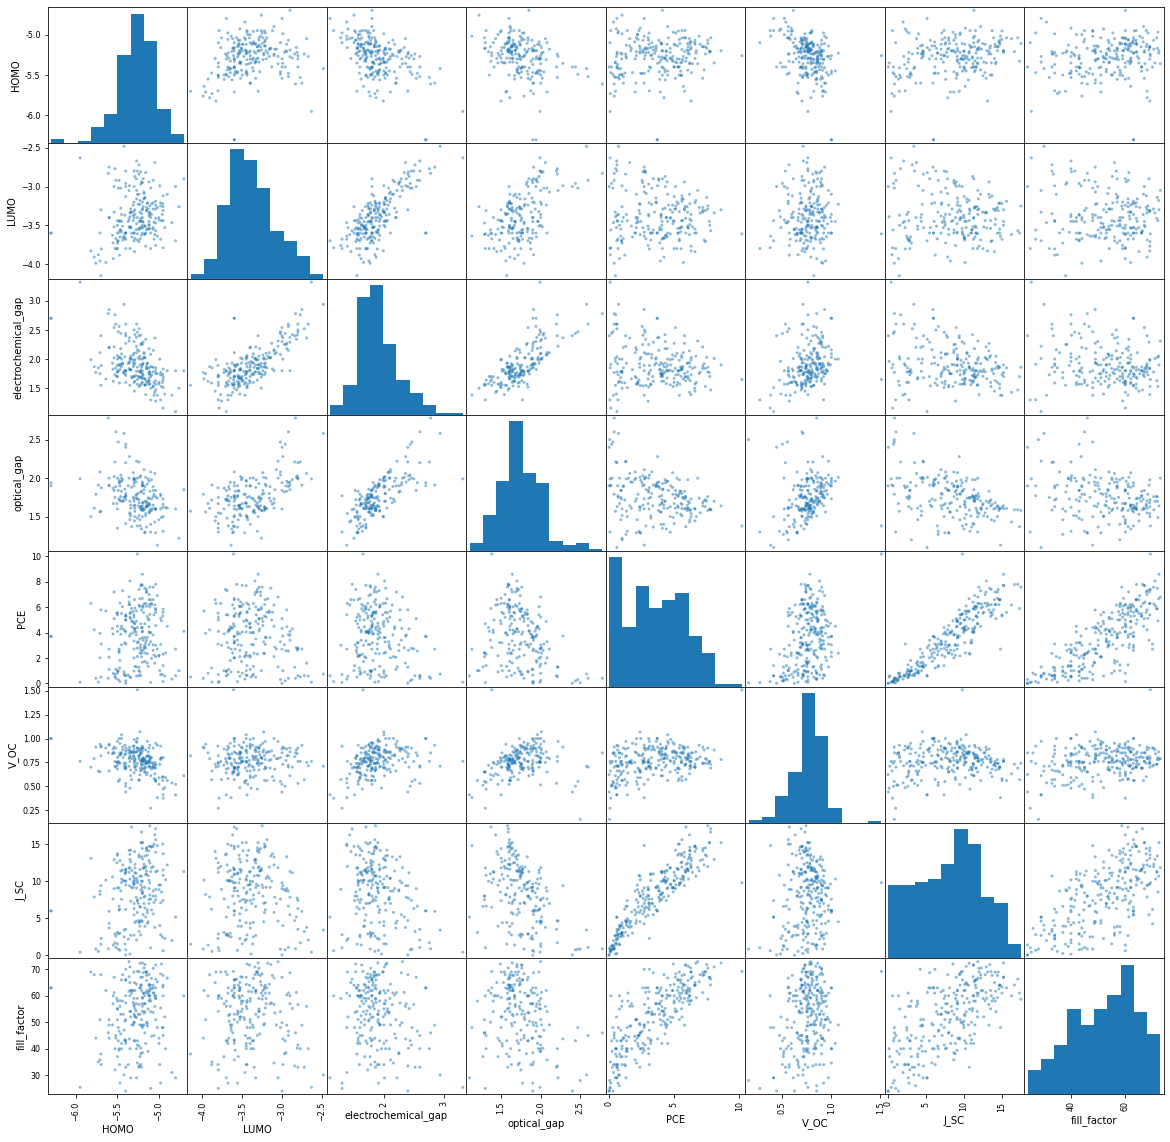

In [4]:
scatter_matrix(hopv_df[hopv_df.architecture=='bulk'],figsize=(20,20))

In [5]:
qm9_df = pd.read_csv('qm9.zip')

In [6]:
qm9_df.describe()

,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
count,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000,133885.000000
mean,9.814382,1.406097,1.124921,2.706037,75.191296,-0.239977,0.011124,0.251100,1189.527450,0.148524,-411.543985,-411.535513,-411.534569,-411.577397,31.600676,-1750.812997,-1761.480647,-1771.546928,-1629.388196
std,1809.465666,1.583795,1.095618,1.530394,8.187793,0.022131,0.046936,0.047519,279.757172,0.033274,40.060230,40.060012,40.060012,40.060741,4.062471,239.313373,241.436103,243.151065,220.207088
min,0.000000,0.337120,0.331180,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,-714.568061,-714.560153,-714.559209,-714.602138,6.002000,-2608.448864,-2626.408172,-2643.007040,-2417.121997
25%,2.554430,1.091630,0.910480,1.588700,70.380000,-0.252500,-0.023800,0.216300,1018.322600,0.125289,-437.913936,-437.905942,-437.904997,-437.947682,28.942000,-1904.772194,-1916.981009,-1928.181417,-1771.350603
50%,3.090360,1.369940,1.078560,2.500000,75.500000,-0.241000,0.012000,0.249400,1147.585800,0.148329,-417.864758,-417.857351,-417.856407,-417.895731,31.555000,-1753.464714,-1764.090324,-1774.151176,-1632.224955
75%,3.835820,1.653980,1.279540,3.636100,80.520000,-0.228700,0.049200,0.288200,1308.816600,0.171150,-387.049166,-387.039746,-387.038802,-387.083279,34.276000,-1596.871098,-1606.108658,-1615.066349,-1488.291333
max,619867.683140,437.903860,282.945450,29.556400,196.620000,-0.101700,0.193500,0.622100,3374.753200,0.273944,-40.478930,-40.476062,-40.475117,-40.498597,46.969000,-213.087624,-213.974294,-215.159658,-201.407171


In this experiment, we are going to rely on the so-called SMILes representation of molecules. QM9 datasets includes the SMILe representation of all available materials in the datasets. Let us look at few examples of this:

In [7]:
print ('Max length of smiles strings in qm9: {}'.format(qm9_df.smiles.map(len).max()))
qm9_df.smiles.sample(10)

Max length of smiles strings in qm9: 29


34830      N#CC1C2OC1C21OC1
40580     C1OC1C1C2C3CC1N23
27656     C#Cc1cc([nH]c1N)N
116594      CCN=C1NC(=O)CO1
109295       CC1CCC=C(CO)C1
103274      CC1CC2C1C2(C)CO
52977      CC#CC12OC1C1NC21
125323      Cc1cnn(c1)C2CC2
102618       CCC(CO)CC(N)=O
122704          CCCOC=NCC#N
Name: smiles, dtype: object

The SMILEs dictionary in the QM9 dataset is based on a specific alphabet / set of symbols. 
At this point, we will prepare helper dictionaries to map each alphabet symbol to an integer number, and to also convert back the numerical representation to the original symbol:

In [8]:
raw_text = ''.join(qm9_df.smiles)
unique_chars = sorted(list(set(raw_text)))
print (unique_chars)

['#', '(', ')', '+', '-', '1', '2', '3', '4', '5', '=', 'C', 'F', 'H', 'N', 'O', '[', ']', 'c', 'n', 'o']


In [9]:
# maps each unique character as int
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
# manually updates \n
char_to_int.update({-1 : "\n"})

# int to char dictionary
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))
int_to_char.update({"\n" : -1})

In [10]:
mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)
print ("Size of the character to integer dictionary is: ", mapping_size)
print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

Size of the character to integer dictionary is:  22
Size of the integer to character dictionary is:  22


## Dataset preparation
Time is now ripe to prepare the datasets for training our LSTM-based models. Since LSTM require fixed shape input samples, the data preparation includes also sequence padding step to build sequences of same seq_length length. 
 * dataX will be the SMILES strings
 * dataY will represent the individual characters in the SMILES string


In [ ]:
seq_length = 50
n_chars = len(raw_text)
n_vocab = len(unique_chars)

print ("Total number of characters in the file is: ", n_chars)


dataX = []
dataY = []

Total number of characters in the file is:  2037532


In [ ]:
for i in range(0, len(qm9_df)):
	seq_in = qm9_df.iloc[i,:].smiles
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append([qm9_df.iloc[i,:].homo, qm9_df.iloc[i,:].lumo])

In [ ]:
padded = pad_sequences(dataX, maxlen=seq_length)

In [ ]:
n_patterns = len(padded)
# re shape input sequence X (using numpy)to be [samples, time steps, physiochemical features], input format for recurrent models
X = np.reshape(padded, (n_patterns, seq_length, 1))

# Normalize the integers in X by dividing by the number of unique SMILES characters (a.k.a vocabulary)
X = X / float(n_vocab)
Y = np.array(dataY)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
Y_scaled = scaler.fit_transform(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_scaled, random_state=1234, test_size=0.2)

# Model definition and training
## Baseline LSTM regressor

In [ ]:
"""CREATING THE LSTM MODEL"""

# Create the model (simple 2 layer LSTM)
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(512, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(128))
model.add(Dropout(0.25))
model.add(Dense(Y.shape[1], activation='relu'))
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 512)           1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 256)           7

In [ ]:
# Compile the model
model.compile(loss = 'mse', optimizer='adam')

In [ ]:
# # Define checkpoints (used to save the weights at each epoch, so that the model doesn't need to be retrained)
filepath="2021_sl50_deeper_relu_minmaxscaledoutput_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

# # Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, batch_size = 512, callbacks = callbacks_list)

Epoch 1/10
210/210 [==============================] - 91s 375ms/step - loss: 0.0175 - val_loss: 0.0096

Epoch 00001: loss improved from inf to 0.01748, saving model to 2021_sl50_deeper_relu_minmaxscaledoutput_weights-improvement-01-0.0175.hdf5
Epoch 2/10
210/210 [==============================] - 78s 370ms/step - loss: 0.0110 - val_loss: 0.0095

Epoch 00002: loss improved from 0.01748 to 0.01101, saving model to 2021_sl50_deeper_relu_minmaxscaledoutput_weights-improvement-02-0.0110.hdf5
Epoch 3/10
210/210 [==============================] - 78s 369ms/step - loss: 0.0107 - val_loss: 0.0094

Epoch 00003: loss improved from 0.01101 to 0.01073, saving model to 2021_sl50_deeper_relu_minmaxscaledoutput_weights-improvement-03-0.0107.hdf5
Epoch 4/10
210/210 [==============================] - 77s 369ms/step - loss: 0.0106 - val_loss: 0.0094

Epoch 00004: loss improved from 0.01073 to 0.01056, saving model to 2021_sl50_deeper_relu_minmaxscaledoutput_weights-improvement-04-0.0106.hdf5
Epoch 5/10
2

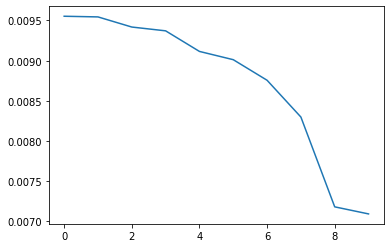

In [ ]:
plt.plot(history.history['val_loss'])

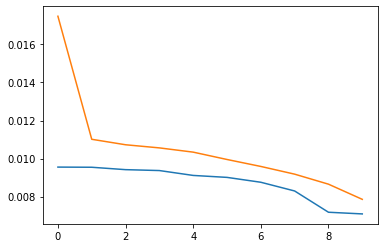

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [ ]:
preds = model.predict(X_test)

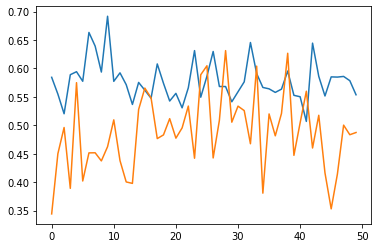

In [ ]:
plt.plot(preds[0:50])

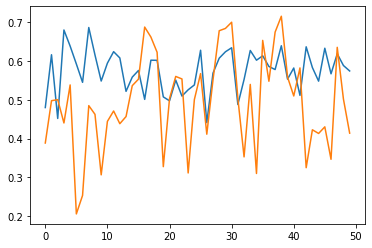

In [ ]:
plt.plot(y_test[0:50])

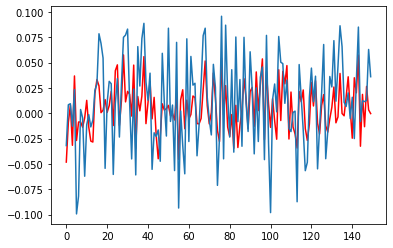

In [ ]:
plt.plot(scaler.inverse_transform(preds)[:150,1],color='red')
plt.plot(scaler.inverse_transform(y_test)[:150,1])

In [ ]:
model.evaluate(X_test, y_test)

837/837 [==============================] - 26s 31ms/step - loss: 0.0071


0.0070930602960288525

## LSTM with embeddings and extended dataset

It is quite clear that the basic LSTM model cannot go too far.
In the next section, we will build an alternative model that tries to improve the input layer with a dedicated embedding layer, which may help the LSTM to encode in a better way the different structures that are used for training.

When training this new type of model, we will also include some new molecules to the datasets, and explore a bit more the model design including also examples from our own extensions to the dataset used so far


In [11]:
hopv_new =pd.DataFrame()
hopv_new['smiles'] = hopv_df.smiles
hopv_new['homo'] = hopv_df.HOMO / 27.2113961 
hopv_new['lumo'] = hopv_df.LUMO / 27.2113961 
all_inclusive = hopv_new.append(qm9_df[['smiles','homo','lumo']])
all_inclusive.smiles.map(len).max()

186

In [12]:
hsc_df = pd.read_csv('Training-molecules.csv',sep=';')

In [13]:
hsc_df.homo = -1 * hsc_df.homo / 27.2113961 
hsc_df.lumo = -1 * hsc_df.lumo / 27.2113961 

In [14]:
print ('Max length of SMILEs strings in QM9 + HOPV dataset: {}'.format(all_inclusive.smiles.map(len).max()))
print ('Max length of SMILEs strings in HSC dataset: {}'.format(hsc_df.smiles.map(len).max()))

Max length of SMILEs strings in QM9 + HOPV dataset: 186
Max length of SMILEs strings in HSC dataset: 262


In [15]:
all_inclusive = all_inclusive.append(hsc_df[['smiles','homo','lumo']])

In [16]:
all_inclusive = all_inclusive.dropna()
raw_text = ''.join(all_inclusive.smiles)
unique_chars = sorted(list(set(raw_text)))
# maps each unique character as int
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
# manually updates \n
char_to_int.update({-1 : "\n"})

# int to char dictionary
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))
int_to_char.update({"\n" : -1})

mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)
print ("Size of the character to integer dictionary is: ", mapping_size)
print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

Size of the character to integer dictionary is:  35
Size of the integer to character dictionary is:  35


In [17]:
n_chars = len(raw_text)
n_vocab = len(unique_chars)

print ("Total number of characters in the file is: ", n_chars)

# Preparring datasets by matching the dataset lengths (dataX will be the SMILES strings and dataY will be individual characters in the SMILE string)
seq_length = 300
dataX_all = []
dataY_all = []
for i in range(0, len(all_inclusive)):
	seq_in = all_inclusive.iloc[i,:].smiles
	dataX_all.append([char_to_int[char] for char in seq_in])
	dataY_all.append([all_inclusive.iloc[i,:].homo, all_inclusive.iloc[i,:].lumo])

Total number of characters in the file is:  2059557


In [18]:
Y_all = pd.DataFrame(np.array(dataY_all))
padded = pad_sequences(dataX_all, maxlen=seq_length)
n_patterns = len(padded)
# re shape input sequence X (using numpy)to be [samples, time steps, physiochemical features], input format for recurrent models
X_all = pd.DataFrame(np.reshape(padded, (n_patterns, seq_length)))
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, Y_all, random_state=1234, test_size=0.2)

In [19]:
lstm_embeddings_hsc_dataset_model = Sequential()
lstm_embeddings_hsc_dataset_model.add(Embedding(1000,10, input_length=seq_length, mask_zero=True))
lstm_embeddings_hsc_dataset_model.add(LSTM(128, return_sequences = True))
lstm_embeddings_hsc_dataset_model.add(Dropout(0.25))
lstm_embeddings_hsc_dataset_model.add(LSTM(256, return_sequences = True))
lstm_embeddings_hsc_dataset_model.add(Dropout(0.25))
lstm_embeddings_hsc_dataset_model.add(LSTM(128))
lstm_embeddings_hsc_dataset_model.add(Dropout(0.25))
lstm_embeddings_hsc_dataset_model.add(Dense(Y_all.shape[1]))
print (lstm_embeddings_hsc_dataset_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 10)           10000     
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          71168     
_________________________________________________________________
dropout (Dropout)            (None, 300, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 256)          394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [20]:
lstm_embeddings_hsc_dataset_model.compile(loss = 'mse', optimizer='adam', metrics=['mse', 'mae', 'mape','msle'])
# # Define checkpoints (used to save the weights at each epoch, so that the model doesn't need to be retrained)
filepath="2021_shallow_embeddings_all_inclusive_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]
epochs = 10
batch_size = 512
# # Fit the model
lstm_embeddings_hsc_dataset_model_history = lstm_embeddings_hsc_dataset_model.fit(X_all_train, y_all_train, validation_data=(X_all_test, y_all_test), epochs = epochs, batch_size = batch_size, callbacks = callbacks_list)

Epoch 1/10
210/210 [==============================] - 843s 4s/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - mape: 4975.7026 - msle: 3.0198e-04 - val_loss: 6.5930e-04 - val_mse: 6.5930e-04 - val_mae: 0.0198 - val_mape: 6075.9771 - val_msle: 1.9357e-04

Epoch 00001: loss improved from inf to 0.00146, saving model to 2021_shallow_embeddings_all_inclusive_weights-improvement-01-0.0015.hdf5
Epoch 2/10
210/210 [==============================] - 821s 4s/step - loss: 7.4986e-04 - mse: 7.4986e-04 - mae: 0.0216 - mape: 5396.8091 - msle: 1.9389e-04 - val_loss: 5.9811e-04 - val_mse: 5.9811e-04 - val_mae: 0.0187 - val_mape: 6598.8989 - val_msle: 1.6788e-04

Epoch 00002: loss improved from 0.00146 to 0.00075, saving model to 2021_shallow_embeddings_all_inclusive_weights-improvement-02-0.0007.hdf5
Epoch 3/10
210/210 [==============================] - 811s 4s/step - loss: 6.9282e-04 - mse: 6.9282e-04 - mae: 0.0206 - mape: 5158.5898 - msle: 1.7588e-04 - val_loss: 5.7208e-04 - val_mse: 5.7208e-04 - 

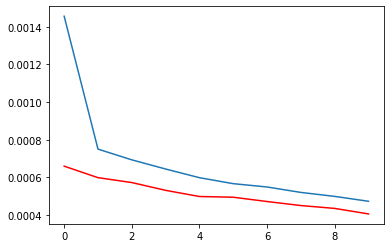

In [21]:
plt.plot(lstm_embeddings_hsc_dataset_model_history.history['val_loss'], color='red')
plt.plot(lstm_embeddings_hsc_dataset_model_history.history['loss'])

In [22]:
lstm_embeddings_hsc_dataset_model_preds=lstm_embeddings_hsc_dataset_model.predict(X_all_test)

In [23]:
lstm_embeddings_hsc_dataset_model.evaluate(X_all_test, y_all_test)

839/839 [==============================] - 167s 199ms/step - loss: 4.0537e-04 - mse: 4.0537e-04 - mae: 0.0150 - mape: 4759.6699 - msle: 1.0347e-04


[0.0004053715383633971,
 0.0004053715383633971,
 0.015043213963508606,
 4759.669921875,
 0.00010346869385102764]

In [ ]:
plt.plot(lstm_embeddings_hsc_dataset_model_preds[0:200,1])
plt.plot(y_all_test.iloc[0:200,1])

In [ ]:
hsc_preds = lstm_embeddings_hsc_dataset_model.predict(X_all[-50:])
plt.plot(hsc_preds[:,0]* 27.211396,color='red')
plt.plot(Y_all.iloc[-50:,0]* 27.211396)

In [ ]:
pd.DataFrame(lstm_embeddings_hsc_dataset_model_preds).plot(kind='density')
pd.DataFrame(y_all_test).plot(kind='density')

# Conv1D based model

It seems the embeddings helped really a lot.
Let us try now to rely more on 1D convolution than LSTM, to test a different input encoding scheme and a faster model for both training and inference

In [32]:
conv1D_embeddings_hsc_dataset_model = Sequential()
conv1D_embeddings_hsc_dataset_model.add(Embedding(1000,10, input_length=seq_length))
conv1D_embeddings_hsc_dataset_model.add(Conv1D(100, 10, activation='relu'))
conv1D_embeddings_hsc_dataset_model.add(Conv1D(100, 10, activation='relu'))
conv1D_embeddings_hsc_dataset_model.add(MaxPooling1D(3))
conv1D_embeddings_hsc_dataset_model.add(Conv1D(160, 10, activation='relu'))
conv1D_embeddings_hsc_dataset_model.add(Conv1D(160, 10, activation='relu'))
conv1D_embeddings_hsc_dataset_model.add(LSTM(128))
conv1D_embeddings_hsc_dataset_model.add(Dropout(0.25))
conv1D_embeddings_hsc_dataset_model.add(Dense(Y_all.shape[1]))
print (conv1D_embeddings_hsc_dataset_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 10)           10000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 291, 100)          10100     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 282, 100)          100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 94, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 85, 160)           160160    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 76, 160)           256160    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)              

In [33]:
conv1D_embeddings_hsc_dataset_model.compile(loss = 'mse', optimizer='adam', metrics=['mse', 'mae', 'mape','msle'])

In [34]:
# # Define checkpoints (used to save the weights at each epoch, so that the model doesn't need to be retrained)
filepath="2021_conv1d_shallow_embeddings_all_inclusive_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]
epochs = 50
batch_size = 512

# # Fit the model
# 15 epochs is already enough to get a decent model. However, the model can still learn and improve for 100 epochs or more without significantly overfitting.
conv1D_embeddings_hsc_dataset_model_history = conv1D_embeddings_hsc_dataset_model.fit(X_all_train, y_all_train, validation_data=(X_all_test, y_all_test), epochs = epochs, batch_size = batch_size, callbacks = callbacks_list)

Epoch 1/50
210/210 [==============================] - 47s 214ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0300 - mape: 4179.3374 - msle: 3.6337e-04 - val_loss: 4.2539e-04 - val_mse: 4.2539e-04 - val_mae: 0.0157 - val_mape: 4831.3486 - val_msle: 8.2422e-05

Epoch 00001: loss improved from inf to 0.00181, saving model to 2021_conv1d_shallow_embeddings_all_inclusive_weights-improvement-01-0.0018.hdf5
Epoch 2/50
210/210 [==============================] - 43s 207ms/step - loss: 4.0509e-04 - mse: 4.0509e-04 - mae: 0.0156 - mape: 3250.1003 - msle: 6.8127e-05 - val_loss: 2.1226e-04 - val_mse: 2.1226e-04 - val_mae: 0.0110 - val_mape: 4297.6895 - val_msle: 4.4919e-05

Epoch 00002: loss improved from 0.00181 to 0.00041, saving model to 2021_conv1d_shallow_embeddings_all_inclusive_weights-improvement-02-0.0004.hdf5
Epoch 3/50
210/210 [==============================] - 43s 207ms/step - loss: 2.9311e-04 - mse: 2.9311e-04 - mae: 0.0132 - mape: 2667.6953 - msle: 4.9080e-05 - val_loss: 1.7274e-04 - va

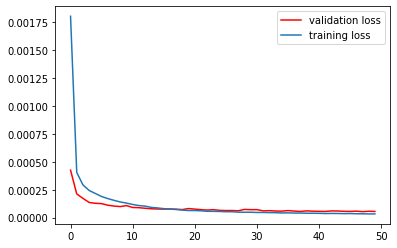

In [35]:
plt.plot(conv1D_embeddings_hsc_dataset_model_history.history['val_loss'], color='red')
plt.plot(conv1D_embeddings_hsc_dataset_model_history.history['loss'])
plt.legend(['validation loss','training loss'])

In [36]:
conv1D_embeddings_hsc_dataset_model = load_model('/content/2021_conv1d_shallow_embeddings_all_inclusive_weights-improvement-15-0.0001.hdf5')

In [37]:
conv1D_embeddings_hsc_dataset_model_preds = conv1D_embeddings_hsc_dataset_model.predict(X_all_test)

In [31]:
conv1D_embeddings_hsc_dataset_model.evaluate(X_all_test, y_all_test)

839/839 [==============================] - 90s 106ms/step - loss: 8.6615e-05 - mse: 8.6615e-05 - mae: 0.0069 - mape: 1550.8105 - msle: 2.0037e-05


[8.661527681397274e-05,
 8.661527681397274e-05,
 0.006865410599857569,
 1550.810546875,
 2.0037357899127528e-05]

Text(0.5, 1.0, 'HOMO level (actual and predicted)')

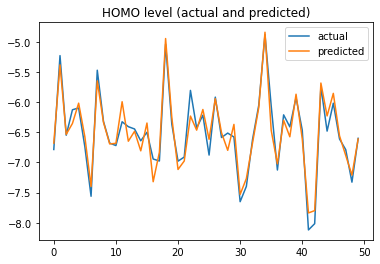

In [43]:
plt.plot(y_all_test.iloc[-50:,0].values*27.2113961)
plt.plot(conv1D_embeddings_hsc_dataset_model_preds[-50:,0]*27.2113961)
plt.legend(['actual','predicted'])
plt.title('HOMO level (actual and predicted)')

Text(0.5, 1.0, 'LUMO level (actual and predicted)')

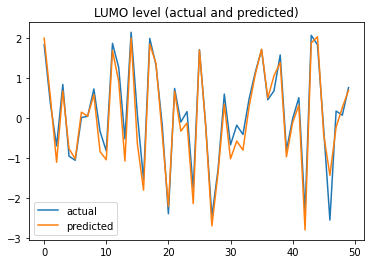

In [44]:
plt.plot(y_all_test.iloc[-50:,1].values*27.2113961)
plt.plot(conv1D_embeddings_hsc_dataset_model_preds[-50:,1]*27.2113961)
plt.legend(['actual','predicted'])
plt.title('LUMO level (actual and predicted)')

Text(0, 0.5, 'predicted')

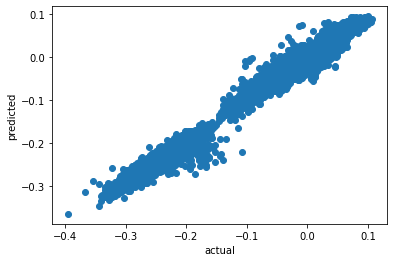

In [38]:
plt.scatter(x=y_all_test, y=conv1D_embeddings_hsc_dataset_model_preds)
plt.xlabel('actual')
plt.ylabel('predicted')

In [39]:
all_inclusive.to_csv('all_inclusive.csv')

In [57]:
molecules_dict = {
  'dpp1' : 'O=C1C(C2=C(C3=CC=C(C4=NC5=C(C(C=CC=C6)=C6C7=C5C=CC=C7)N4C8=CC=CC=C8)C=C3)N1CC(CCCC)CC)=C(C9=CC=C(C%10=NC%11=C(C(C=CC=C%12)=C%12C%13=C%11C=CC=C%13)N%10C%14=CC=CC=C%14)C=C9)N(CC(CCCC)CC)C2=O',
  'dppocz' : 'O=C1C(C2=C(C3=CC=C(C4=NN=C(C5=CC=C(C6=CC(N(CCCCCCCCCCCCCC)C7=C8C=CC=C7)=C8C=C6)C=C5)O4)C=C3)N1CCCCCCCC)=C(C9=CC=C(C%10=NN=C(C%11=CC=C(C%12=CC(N(CCCCCCCCCCCCCC)C%13=C%14C=CC=C%13)=C%14C=C%12)C=C%11)O%10)C=C9)N(CCCCCCCC)C2=O',
  'dppbp1' : 'O=C1C(C2=C(C3=CC=C(C4=CC=C(C5=NC6=C(C(C=CC=C7)=C7C8=C6C=CC=C8)N5C9=CC=CC=C9)C=C4)C=C3)N1CC(CCCC)CC)=C(C%10=CC=C(C%11=CC=C(C%12=NC%13=C(C(C=CC=C%14)=C%14C%15=C%13C=CC=C%15)N%12C%16=CC=CC=C%16)C=C%11)C=C%10)N(CC(CCCC)CC)C2=O',
  'dppbp' : 'O=C1C(C2=C(C3=CC=C(C4=NC(C5=CC=CC=C5)C(C6=CC=CC=C6)N4C7=CC=CC=C7)C=C3)N1CC(CCCC)CC)=C(C8=CC=C(C9=NC(C%10=CC=CC=C%10)C(C%11=CC=CC=C%11)N9C%12=CC=CC=C%12)C=C8)N(CC(CCCC)CC)C2=O',
  'dppbb1_1' : 'O=C1C(C2=C(C3=CC=C(C4=CC=C(C5=NC(C6=CC=CC=C6)C(C7=CC=CC=C7)N5C8=CC=CC=C8)C=C4)C=C3)N1CCCCCCCC)=C(C9=CC=C(C%10=CC=C(C%11=NC(C%12=CC=CC=C%12)C(C%13=CC=CC=C%13)N%11C%14=CC=CC=C%14)C=C%10)C=C9)N(CCCCCCCC)C2=O',
  'dppbb1_2' : 'O=C1C(C2=C(C3=CC=C(C4=CC=C(C5=NC(C6=CC=CC=C6)C(C7=CC=CC=C7)N5C8=CC=CC=C8)C=C4)C=C3)N1CC(CC)CCCC)=C(C9=CC=C(C%10=CC=C(C%11=NC(C%12=CC=CC=C%12)C(C%13=CC=CC=C%13)N%11C%14=CC=CC=C%14)C=C%10)C=C9)N(CC(CC)CCCC)C2=O',
  'dppbb1_3' : 'O=C1C(C2=C(C3=CC=C(C4=NC(C5=CC=C(C6=CC=C(N(C7=CC=CC=C7)C8=CC=CC=C8)C=C6)C=C5)C(C9=CC=C(C%10=CC=C(N(C%11=CC=CC=C%11)C%12=CC=CC=C%12)C=C%10)C=C9)N4C%13=CC=CC=C%13)C=C3)N1CC(CCCC)CC)=C(C%14=CC=C(C%15=NC(C%16=CC=C(C%17=CC=C(N(C%18=CC=CC=C%18)C%19=CC=CC=C%19)C=C%17)C=C%16)C(C%20=CC=C(C%21=CC=C(N(C%22=CC=CC=C%22)C%23=CC=CC=C%23)C=C%21)C=C%20)N%15C%24=CC=CC=C%24)C=C%14)N(CC(CCCC)CC)C2=O',
  'btoc8' : 'CCCCCCCCOC(C=C1)=CC=C1C2=C3C(N=C(C4=CC=C(C5=CC=C(N(C6=CC=C(OCCCCCCCC)C=C6)C7=CC=C(OCCCCCCCC)C=C7)C=C5)C=C4)C(C8=CC=C(C9=CC=C(N(C%10=CC=C(OCCCCCCCC)C=C%10)C%11=CC=C(OCCCCCCCC)C=C%11)C=C9)C=C8)=N3)=C(C%12=CC=C(OCCCCCCCC)C=C%12)C%13=NSN=C%132',
  'hz1' : 'CC1=CC2=C(C3=CC=C(CCCCCCCC)S3)C4=C(C=C(C(S5)=C(CCCCCCCCCCCCCCCCCCCC)C=C5C6=C(F)C(F)=C(C7=CC(CCCCCCCCCCCCCCCCCCCC)=C(C)S7)C8=NSN=C86)S4)C(C9=CC=C(CCCCCCCC)S9)=C2S1',
  'hz3' : '[*]C(S1)=C(CC(CCCCCCCCCC)CCCCCCCC)C=C1C2=C(F)C(F)=C(C3=CC(CC(CCCCCCCC)CCCCCCCCCC)=C(C4=C(F)C(F)=C([*])S4)S3)C5=NSN=C52',
  'hz4' : '[*]C(S1)=C(CC(CCCCCCCCCC)CCCCCCCC)C=C1C2=C(F)C(F)=C(C3=CC(CC(CCCCCCCC)CCCCCCCCCC)=C(C4=CC=C([*])S4)S3)C5=NSN=C52',
  'hz5' : '[*]C(S1)=C(CC(CCCCCCCCCC)CCCCCCCC)C=C1C2=C(F)C(F)=C(C3=CC(CC(CCCCCCCC)CCCCCCCCCC)=C(C4=CC=C(C5=CC=C(C)S5)S4)S3)C6=NSN=C62',
  'spiro' : 'COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=C3)C5=C(C46C7=C(C=CC(=C7)N(C8=CC=C(C=C8)OC)C9=CC=C(C=C9)OC)C1=C6C=C(C=C1)N(C1=CC=C(C=C1)OC)C1=CC=C(C=C1)OC)C=C(C=C5)N(C1=CC=C(C=C1)OC)C1=CC=C(C=C1)OC',
  'adams' : 'O=C(N(C1=CC=C(N(C2=CC=C(OC)C=C2)C3=CC=C(OC)C=C3)C=C1)C4=O)C5=C4C=C(C(N(C6=CC=C(N(C7=CC=C(OC)C=C7)C8=CC=C(OC)C=C8)C=C6)C9=O)=O)C9=C5',
  'unnamed_1_20190617' : 'O=C(C(C=CC=C1)=C1C/2=O)C2=C\\C3=CC(CCCCCCCC)=C(S3)C4=CC=C(C5=C(CCCCCCCC)C=C(/C=C6C(C(C=CC=C7)=C7C\\6=O)=O)S5)C8=NSN=C84',
  'unnamed_2_20190617' : 'O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(CCCCCCCC)=C(S3)C4=CC=C(C5=C(CCCCCCCC)C=C(/C=C6C(C(C=CC=C7)=C7C\\6=C(C#N)\C#N)=O)S5)C8=NSN=C84)=C(C#N)/C#N',
  'pv' : 'C/C=C(\C=C)N(C1=CC=C(C2=CC=C3C(SC(C=C(/C=C(C#N)/C#N)C=C4)=C4N3CC(CCCC)CC)=C2)C=C1)C5=CC=CC=C5',
  'pc60bm' : 'COC(=O)CCCC1(C23C14C5=C6C7=C8C5=C9C1=C5C%10=C%11C%12=C%13C%10=C%10C1=C8C1=C%10C8=C%10C%14=C%15C%16=C%17C(=C%12C%12=C%17C%17=C%18C%16=C%16C%15=C%15C%10=C1C7=C%15C1=C%16C(=C%18C7=C2C2=C%10C(=C5C9=C42)C%11=C%12C%10=C%177)C3=C16)C%14=C%138)C1=CC=CC=C1',
  'triph' : 'C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=CC=C3',
  'phenoth' : 'C1=CC=C2C(=C1)NC3=CC=CC=C3S2',
  'tp_incn' : 'O=C1C2=C(C=CC=C2)C(/C1=C/C(S3)=CC(CCCCCCCC)=C3C(C=C4)=CC=C4N(C5=CC=C(C6=C(CCCCCCCC)C=C(/C=C7C(C(C=CC=C8)=C8C\\7=C(C#N)/C#N)=O)S6)C=C5)C9=CC=C(C%10=C(CCCCCCCC)C=C(/C=C%11/C(C(C=CC=C%12)=C%12C%11=O)=C(C#N)/C#N)S%10)C=C9)=C(C#N)\\C#N',
  'tpa_2t_incn' : 'O=C(C(C=CC=C1)=C1C/2=C(C#N)\\C#N)C2=C/C3=C(CCCCCCCC)C=C(C4=CC(CCCCCCCC)=C(S4)C(C=C5)=CC=C5N(C6=CC=C(C7=C(CCCCCCCC)C=C(C8=CC(CCCCCCCC)=C(/C=C9/C(C(C=CC=C%10)=C%10C9=O)=C(C#N)/C#N)S8)S7)C=C6)C%11=CC=C(C%12=C(CCCCCCCC)C=C(C%13=CC(CCCCCCCC)=C(/C=C%14/C(C(C=CC=C%15)=C%15C%14=O)=C(C#N)/C#N)S%13)S%12)C=C%11)S3'
}

In [62]:
encoded_molecules = molecules_dict.copy()
padded_2 = []
for k,v in molecules_dict.items():
  print (k)
  encoded_molecules[k] = ([char_to_int[char] for char in v])
  padded_2.append(encoded_molecules[k])
padded_2 = pad_sequences(padded_2, maxlen=seq_length)

dpp1
dppocz
dppbp1
dppbp
dppbb1_1
dppbb1_2
dppbb1_3
btoc8
hz1
hz3
hz4
hz5
spiro
adams
unnamed_1_20190617
unnamed_2_20190617
pv
pc60bm
triph
phenoth
tp_incn
tpa_2t_incn


In [65]:
extra_molecules_pred = conv1D_embeddings_hsc_dataset_model.predict(padded_2) * 27.2113961

In [ ]:
lstm_embeddings_hsc_dataset_model_extra_molecules_pred = lstm_embeddings_hsc_dataset_model.predict(padded_2) * 27.2113961

In [68]:
preds_df = pd.DataFrame(extra_molecules_pred, index = encoded_molecules.keys(),columns=['HOMO','LUMO'])

In [69]:
preds_df

,HOMO,LUMO
dpp1,-4.865354,-2.606347
dppocz,-4.915956,-3.068440
dppbp1,-5.011935,-3.604754
dppbp,-4.916236,-2.869579
dppbb1_1,-4.842614,-3.037779
dppbb1_2,-4.805281,-2.875716
dppbb1_3,-4.814995,-3.393434
btoc8,-5.197331,-3.381890
hz1,-5.501702,-3.807991
hz3,-5.111139,-4.094790
